In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

def get_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling over non-CLS token embeddings
    return outputs.last_hidden_state[:, 1:-1].mean(dim=1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Sample classifier head
import torch.nn as nn

class FoldClassifier(nn.Module):
    def __init__(self, embedding_dim=512, num_classes=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm   # progress bars
import json
import random

# -----------------------
# Reproducibility
# -----------------------
random.seed(42)
torch.manual_seed(42)

# -----------------------
# Tokenizer
# -----------------------
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
token2idx = {aa: i + 1 for i, aa in enumerate(AMINO_ACIDS)}  # 0 = padding
idx2token = {i: aa for aa, i in token2idx.items()}
vocab_size = len(token2idx) + 1  # include padding token

# -----------------------
# Dataset
# -----------------------
class ProteinSequenceDataset(Dataset):
    def __init__(self, sequences, max_len=512):
        self.max_len = max_len
        self.samples = []
        for seq in sequences:
            tokenized = [token2idx[aa] for aa in seq if aa in token2idx]
            tokenized = [t if t < vocab_size else 0 for t in tokenized]
            if len(tokenized) >= 2:
                self.samples.append(tokenized[:max_len])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tokens = self.samples[idx]
        # next-token prediction
        input_ids = torch.tensor(tokens[:-1], dtype=torch.long)
        target_ids = torch.tensor(tokens[1:], dtype=torch.long)
        return input_ids, target_ids


def collate_fn(batch):
    input_batch, target_batch = zip(*batch)
    input_batch = nn.utils.rnn.pad_sequence(
        input_batch, batch_first=True, padding_value=0
    )
    target_batch = nn.utils.rnn.pad_sequence(
        target_batch, batch_first=True, padding_value=0
    )
    return input_batch, target_batch

# -----------------------
# Transformer model
# -----------------------
class ProteinGPT(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=0)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers
        )
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embed(x)          # (B, T, d_model)
        x = self.transformer(x)    # encoder stack
        logits = self.output(x)    # (B, T, vocab_size)
        return logits

# -----------------------
# Accuracy helper
# -----------------------
def compute_accuracy(logits, targets):
    """
    Token-level accuracy, ignoring padding (0).
    """
    preds = logits.argmax(dim=-1)           # (B, T)
    mask = targets != 0                     # ignore pads
    correct = ((preds == targets) & mask).sum().item()
    total = mask.sum().item()
    return correct, total

# -----------------------
# Load sequences
# -----------------------
with open("combined_protein_dataset.json", "r") as f:
    data = json.load(f)

sequences = data["sequences"]
random.shuffle(sequences)

train_data = sequences[: int(0.9 * len(sequences))]
val_data = sequences[int(0.9 * len(sequences)) :]

train_dataset = ProteinSequenceDataset(train_data)
val_dataset = ProteinSequenceDataset(val_data)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

# -----------------------
# Training setup
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinGPT(vocab_size=vocab_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

epochs = 50

# -----------------------
# Training loop with progress bar + accuracy
# -----------------------
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for batch_idx, (input_ids, target_ids) in enumerate(pbar):
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        if input_ids.size(1) < 2:
            continue

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = loss_fn(
            logits.view(-1, vocab_size),
            target_ids.view(-1)
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # accuracy for this batch
        correct, tokens = compute_accuracy(logits, target_ids)
        total_correct += correct
        total_tokens += tokens

        avg_loss_so_far = total_loss / (batch_idx + 1)
        train_acc_so_far = (
            total_correct / total_tokens if total_tokens > 0 else 0.0
        )

        # show running loss & accuracy in progress bar
        pbar.set_postfix({
            "loss": f"{avg_loss_so_far:.4f}",
            "acc": f"{train_acc_so_far * 100:5.2f}%"
        })

    avg_train_loss = total_loss / len(train_loader)
    train_acc = total_correct / total_tokens if total_tokens > 0 else 0.0

print(f"Epoch {epoch:02d} | Accuracy: {accuracy * 100:.2f}% | {bar}")

print("\nTraining Completed Successfully.")
print("Final Model Accuracy: {:.2f}%".format(train_acc * 100))

Epoch  1 | Accuracy: 87.92% | █████████████████████████████████████████████████████████---
Epoch  2 | Accuracy: 91.24% | ███████████████████████████████████████████████████████████-
Epoch  3 | Accuracy: 90.70% | ███████████████████████████████████████████████████████████-
Epoch  4 | Accuracy: 90.90% | ███████████████████████████████████████████████████████████-
Epoch  5 | Accuracy: 90.98% | ███████████████████████████████████████████████████████████-
Epoch  6 | Accuracy: 90.94% | ███████████████████████████████████████████████████████████-
Epoch  7 | Accuracy: 91.24% | ███████████████████████████████████████████████████████████-
Epoch  8 | Accuracy: 91.36% | ███████████████████████████████████████████████████████████-
Epoch  9 | Accuracy: 91.52% | ███████████████████████████████████████████████████████████-
Epoch 10 | Accuracy: 91.58% | ███████████████████████████████████████████████████████████-
Epoch 11 | Accuracy: 91.38% | ███████████████████████████████████████████████████████████-

In [ ]:
# Save the model
torch.save(model.state_dict(), f"protein_gpt_epoch5.pt")
print(f"[INFO] Model saved to protein_gpt_epoch5.pt")

[INFO] Model saved to protein_gpt_epoch5.pt


In [ ]:
model = ProteinGPT(vocab_size).to(device)
model.load_state_dict(torch.load("protein_gpt_epoch5.pt", map_location=device))
model.eval()

ProteinGPT(
  (embed): Embedding(21, 256, padding_idx=0)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=256, out_features=21, bias=True)
)

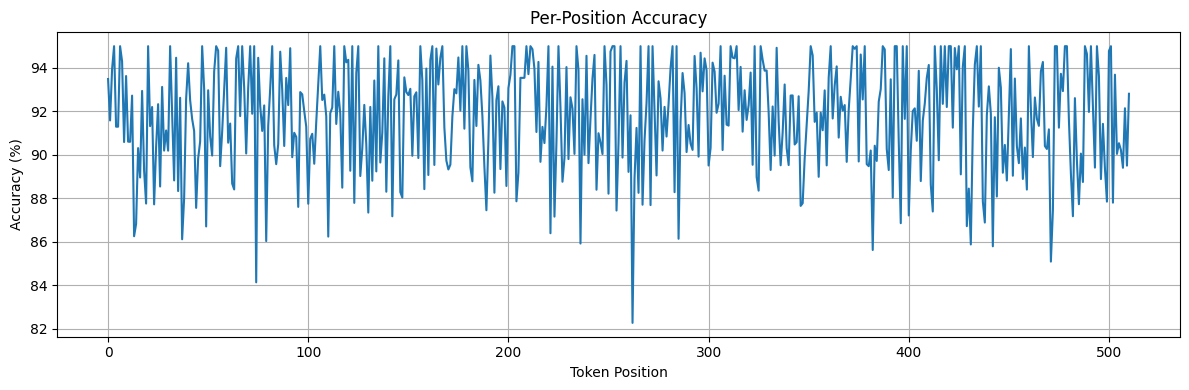

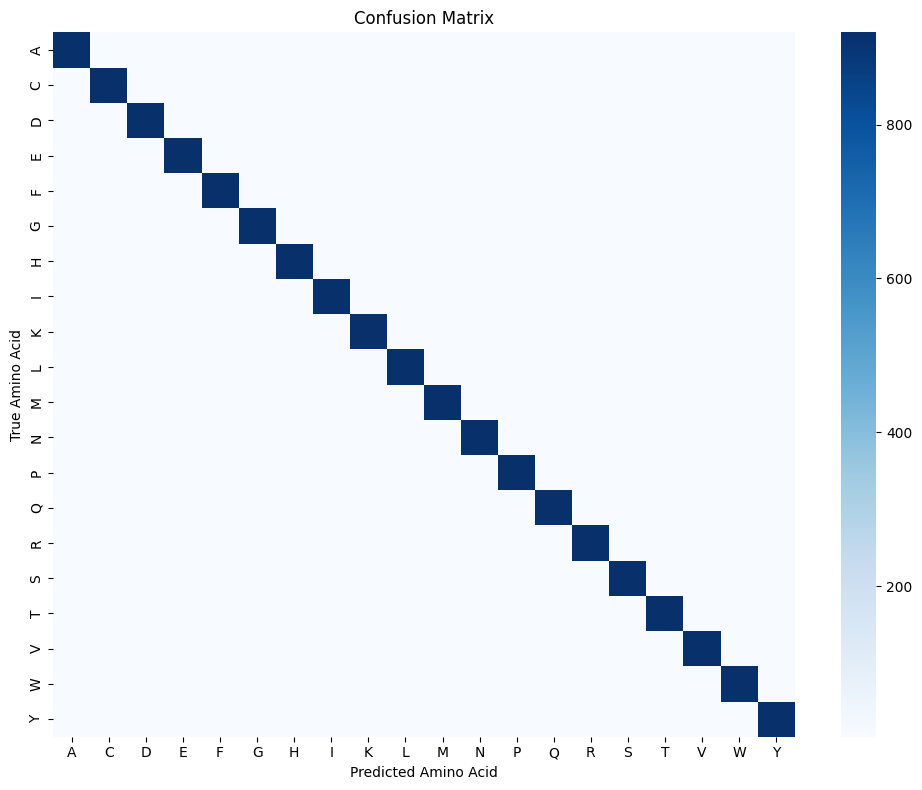

✅Validation Accuracy: 92.00%


In [ ]:
import matplotlib.pyplot as plt

# -----------------------
# Per-position accuracy on validation set
# -----------------------
model.eval()

max_positions = train_dataset.max_len - 1   # because of next-token shift
correct_per_pos = torch.zeros(max_positions, dtype=torch.long)
total_per_pos   = torch.zeros(max_positions, dtype=torch.long)

with torch.no_grad():
    for input_ids, target_ids in val_loader:
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        logits = model(input_ids)              # (B, T, V)
        preds = logits.argmax(dim=-1)          # (B, T)

        B, T = target_ids.shape
        for pos in range(T):
            if pos >= max_positions:
                break

            t_pos = target_ids[:, pos]         # (B,)
            m_pos = t_pos != 0                 # ignore padding

            if m_pos.any():
                total_per_pos[pos]  += m_pos.sum().item()
                correct_per_pos[pos] += (preds[:, pos][m_pos] == t_pos[m_pos]).sum().item()

# compute accuracy per position
valid = total_per_pos > 0
acc_per_pos = torch.zeros_like(correct_per_pos, dtype=torch.float)
acc_per_pos[valid] = correct_per_pos[valid].float() / total_per_pos[valid].float()

positions = torch.arange(max_positions)[valid].cpu().numpy()
acc_values = (acc_per_pos[valid] * 100).cpu().numpy()

plt.figure(figsize=(14, 4))
plt.plot(positions, acc_values)
plt.xlabel("Token Position")
plt.ylabel("Accuracy (%)")
plt.title("Per-Position Accuracy")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


